In [1]:
import numpy as np 
import pandas as pd 
import statistics
import os 
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
def get_normalized_sensitivity(features, df):
    '''filter features and normalilze sensitivity
    '''
    sensitivity_sum = df['0'].sum()
    sensitivities = []
    normalized_sensitivities = []
    for feature in features:
        row = df[df['Unnamed: 0']==feature]
        if not row.empty:
            sens = row['0'].values[0]
            sensitivities.append(sens)
            normalized_sensitivities.append(sens/sensitivity_sum)
        else: 
            raise ValueError(f'feauture not found: {feature}')
    return pd.DataFrame({
        "features": features,
        "sensitivity_normalized": normalized_sensitivities
    })
def plot_box_chart(features, medians, lower_percentiles, upper_percentiles, targets=None, order = None, title='', save=False, colors = None):
        if not order:
            order = np.argsort(medians)[::-1]
        features = [features[i] for i in order]
        medians = [medians[i] for i in order]
        lower_percentiles = [lower_percentiles[i] for i in order]
        upper_percentiles = [upper_percentiles[i] for i in order]
        lower_errors = [mean - lower for mean, lower in zip(medians, lower_percentiles)]
        upper_errors = [upper - mean for mean, upper in zip(medians, upper_percentiles)]
        plt.figure()
        if colors: 
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5, color=colors)
        else:
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5)
        if targets: 
            for i, bar in enumerate(bar_plot):
                plt.scatter(targets[i], bar.get_y() + bar.get_height()/2, color='red', marker='o', zorder=5)
        plt.xlabel('Sensitivity')
        plt.title('Sensitivity Box Chart '+title)
        plt.gca().invert_yaxis()
        if save:
            plt.savefig("individual_variable_box_chart{}.png".format(title), dpi=300, bbox_inches='tight')
        plt.show()

In [3]:
def plot_sensitivity_with_boostrap(M, N, features, dirname='sensitivity_bond/', normalize=True, graph=True):
    #read all files
    files = os.listdir(dirname)
    files = [_ for _ in files if "sensitivity_" in _]
    df_main = pd.DataFrame()
    name_dict = {}
    #get all sensitivity numbers
    for file_ind in tqdm(range(len(files))):
        file = files[file_ind]
        if normalize:
            df_temp = pd.read_csv(dirname + file)
            df = get_normalized_sensitivity(features, df_temp)
            df.set_index('features', inplace=True)
        else:
            df = pd.read_csv(dirname + file, index_col=0)
            df = df.loc[features]
            #df['0'] = df['0']*100
        df.columns = [file_ind]
        name_dict[file_ind] = file
        df_main = pd.concat([df_main, df], axis=1)
    df_array = df_main.to_numpy()
    #boostrap process
    inds = np.random.choice(range(len(files)), size=(M, N))
    vals = np.mean(df_array[:, inds], axis=1) #take mean across M models
    p75 = np.percentile(vals, 75, axis=1)
    p25 = np.percentile(vals, 25, axis=1)
    median = np.median(vals, axis=1)
    if graph:
        plot_box_chart(features, median, p25, p75, title=f'N{N}M{M}')
    ########
    num = (p75 - p25 )/median
    ########
    return name_dict, num

100%|██████████| 1945/1945 [00:09<00:00, 209.01it/s]


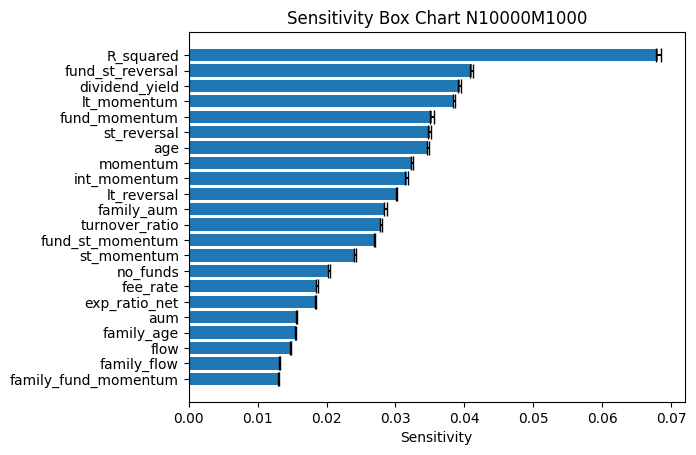

({0: 'sensitivity_1725798831590.csv',
  1: 'sensitivity_1725827347564.csv',
  2: 'sensitivity_1725786068439.csv',
  3: 'sensitivity_1725778200541.csv',
  4: 'sensitivity_1725818928449.csv',
  5: 'sensitivity_1725780385491.csv',
  6: 'sensitivity_1725791189546.csv',
  7: 'sensitivity_1725786244631.csv',
  8: 'sensitivity_1725780273475.csv',
  9: 'sensitivity_1725798624584.csv',
  10: 'sensitivity_1725800384475.csv',
  11: 'sensitivity_1725794282507.csv',
  12: 'sensitivity_1725806403430.csv',
  13: 'sensitivity_1725786945464.csv',
  14: 'sensitivity_1725824592485.csv',
  15: 'sensitivity_1725827698440.csv',
  16: 'sensitivity_1725822771428.csv',
  17: 'sensitivity_1725812211482.csv',
  18: 'sensitivity_1725784705546.csv',
  19: 'sensitivity_1725798443570.csv',
  20: 'sensitivity_1725784694539.csv',
  21: 'sensitivity_1725790795545.csv',
  22: 'sensitivity_1725804080610.csv',
  23: 'sensitivity_1725798330538.csv',
  24: 'sensitivity_1725820123599.csv',
  25: 'sensitivity_1725779262589.cs

In [4]:
feature_names = ['flow', 'aum', 'dividend_yield', 'exp_ratio_net', 'fee_rate',
                       'turnover_ratio',
                       'st_reversal', 'st_momentum', 'momentum', 'int_momentum', 'lt_momentum', 'lt_reversal',
                       'age', 'R_squared', 'fund_st_reversal', 'fund_st_momentum', 'fund_momentum', 'family_flow',
                       'family_aum', 'family_age', 'family_fund_momentum', 'no_funds']
plot_sensitivity_with_boostrap(M=1000, N=10000, features=feature_names, dirname='sensitivity_bond_20240908/', normalize = True)

100%|██████████| 1945/1945 [00:02<00:00, 923.21it/s]


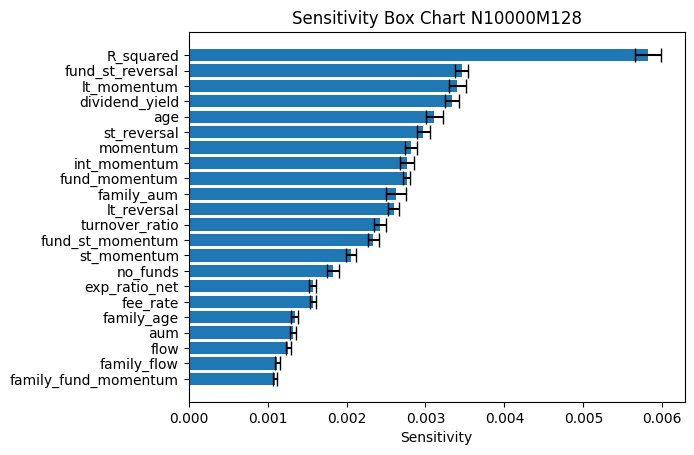

In [5]:
name_dict, _ = plot_sensitivity_with_boostrap(M=128, N=10000, features=feature_names, dirname='sensitivity_bond_20240908/', normalize = False)

In [8]:
def plot_sensitivity_trend(savepath=None):
    #plot sensitivity trend for each feature 
    feature_trends = []
    for feature_idx in tqdm(range(len(feature_names))):
        curr_future = [feature_names[feature_idx]]
        nums = []
        for M in [2**n for n in range(1, 11)]:
            name_dict, num = plot_sensitivity_with_boostrap(M, 10000, curr_future, dirname='sensitivity_bond_20240908/', normalize=False, graph=False)
            nums.append(num[0])
        feature_trends.append(nums)
    plt.figure()
    for i in tqdm(range(len(feature_trends))):
        plt.plot(range(1, 11), feature_trends[i], label = f'{feature_names[i]}')
    plt.xlabel('M values')
    plt.ylabel('(75th - 25th)/median')
    plt.legend(loc='upper right', fontsize=7, borderpad=0.5, labelspacing=0.3)
    if savepath is not None:
        plt.savefig()
    plt.show()

100%|██████████| 22/22 [00:00<00:00, 1698.57it/s]


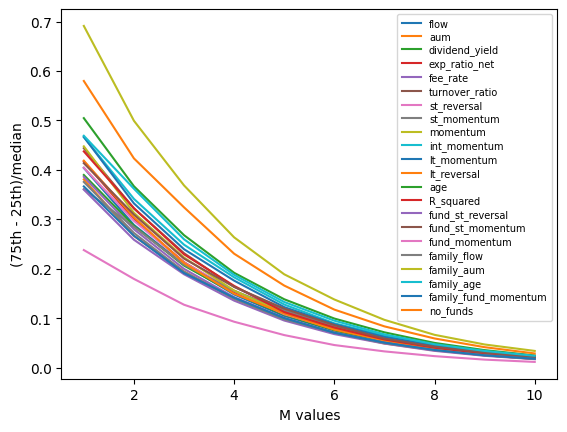

In [9]:
plot_sensitivity_trend()